# Libraries

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
import keras_tuner as kt


In [4]:
image = Image.open("./dataset/train/Bacteria/image_255.jpg")
image.show()

In [5]:
image.size

(512, 512)

# Train, Val, and Test Dataset

In [31]:
dataset_dir = "../dataset/train"
# Get class names (subfolder names)
class_names = sorted(os.listdir(dataset_dir))
print("Class Names:", class_names)

Class Names: ['Bacteria', 'Fungi', 'Healthy', 'Pests', 'Virus']


In [4]:
import tensorflow as tf
dataset_dir = "../dataset/train"

batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    label_mode="categorical",
    validation_split=0.2,  # 20% for validation
    seed=2025,
    subset="training"
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    dataset_dir,
    batch_size=batch_size,
    label_mode="categorical",
    validation_split=0.2,
    seed=2025,
    subset="validation"
)

Found 39997 files belonging to 5 classes.
Using 31998 files for training.


2025-03-11 11:57:09.227238: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 39997 files belonging to 5 classes.
Using 7999 files for validation.


In [5]:
print("Number of baches in train dataset: ", len(train_ds))
print("Number of baches in val dataset: ", len(val_ds))

Number of baches in train dataset:  1000
Number of baches in val dataset:  250


I will reduce the number of baches to search and train model, I have limited computation power.

In [6]:
subset_size = 100  # Number of batches to use
train_ds = train_ds.take(subset_size)  # Take only `subset_size` batches
subset_size = 20  # Number of batches to use
val_ds = val_ds.take(subset_size)  # Take only `subset_size` batches

# Looking at the Batch

Image shape: (256, 256, 3), Label: [0. 0. 0. 0. 1.]


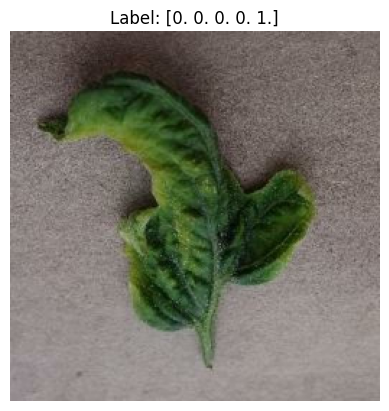

In [7]:
# Get one batch from train_ds
batch = next(iter(train_ds))

# Extract images and labels from the batch
images, labels = batch

# Get the first image and label
one_image = images[0]
one_label = labels[0]

# Show shape
print(f"Image shape: {one_image.shape}, Label: {one_label.numpy()}")

# Plot the image
plt.imshow(one_image.numpy().astype("uint8"))  # Convert to uint8 if needed
plt.title(f"Label: {one_label.numpy()}")
plt.axis("off")
plt.show()


# Search the best model

In [ ]:
def build_model(hp):
    # Hyperparameters
    n_hidden = hp.Int("n_hidden", min_value=0, max_value=8, default=2)
    n_neurons = hp.Int("n_neurons", min_value=16, max_value=256)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=1e-2, sampling="log")
    optimizer = hp.Choice("optimizer", values=["sgd", "adam"])

    # Optimizer selection
    if optimizer == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    # Model definition
    model = tf.keras.Sequential([
        # Normalize input: Rescale pixel values (0-255) to (0-1)
        tf.keras.layers.Rescaling(1./255, input_shape=(256, 256, 3)),

        # Flatten before passing to dense layers
        tf.keras.layers.Flatten()
    ])
    
    # Add hidden layers based on hyperparameter tuning
    for _ in range(n_hidden):
        model.add(tf.keras.layers.Dense(n_neurons, activation="relu"))

    # Output layer (assuming 10 classes, adjust if needed)
    model.add(tf.keras.layers.Dense(5, activation="softmax"))

    # Compile the model
    model.compile(
        loss="categorical_crossentropy",  # ✅ Use this for one-hot labels #loss="sparse_categorical_crossentropy",
        optimizer=optimizer,
        metrics=["accuracy"]
    )

    return model


In [5]:
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=5,
    executions_per_trial=1,  # Run each model once
    directory="kt_logs",
    project_name="image_classification_tuning"
)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",  # 🔍 Monitor validation loss
    patience=10,  # ⏳ Stop after 10 epochs without improvement
    restore_best_weights=True  # ♻️ Revert to the best model
)

Reloading Tuner from kt_logs/image_classification_tuning/tuner0.json


In [14]:

tuner.search(train_ds, 
            validation_data=val_ds, 
            epochs=5,
            callbacks=[early_stopping_cb])


Trial 5 Complete [00h 01m 17s]
val_accuracy: 0.5

Best val_accuracy So Far: 0.582812488079071
Total elapsed time: 00h 04m 04s


# Best model

In [6]:
top3_models = tuner.get_best_models(num_models=3) 
best_model = top3_models[0]

2025-03-11 17:09:27.358630: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57409536 exceeds 10% of free system memory.
2025-03-11 17:09:27.389715: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57409536 exceeds 10% of free system memory.


In [30]:
# Get the best hyperparameters
top3_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)

# Print each model's hyperparameters
for i, hp in enumerate(top3_hyperparameters):
    print(f"🔹 Best Model {i+1} Hyperparameters:")
    print(f"  - n_hidden: {hp.get('n_hidden')}")
    print(f"  - n_neurons: {hp.get('n_neurons')}")
    print(f"  - learning_rate: {hp.get('learning_rate')}")
    print(f"  - optimizer: {hp.get('optimizer')}")
    print("-" * 40)


🔹 Best Model 1 Hyperparameters:
  - n_hidden: 2
  - n_neurons: 73
  - learning_rate: 0.0001321043312961862
  - optimizer: sgd
----------------------------------------


In [12]:
from pathlib import Path 
from time import strftime 

def get_run_logdir(root_logdir="my_logs"):
	return Path(root_logdir) / strftime("run_%Y_%m_%d_%H_%M_%S") 

run_logdir = get_run_logdir()

In [20]:
# Define the TensorBoard callback
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=run_logdir)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_logs/model_{epoch:02d}-{val_loss:.2f}.weights.h5", 
                                                    save_weights_only=True,
                                                    save_freq="epoch"
                                                    )

run the tensorboard 
``` 
tensorboard --logdir=./my_logs 
```

In [21]:
best_model.fit(train_ds, 
                epochs=20,
                validation_data=val_ds,
                callbacks=[tensorboard_cb, checkpoint_cb]
                ) 

Epoch 1/20


100/100 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - accuracy: 0.7003 - loss: 0.8712 - val_accuracy: 0.6297 - val_loss: 1.0054
Epoch 2/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - accuracy: 0.7187 - loss: 0.8543 - val_accuracy: 0.6406 - val_loss: 0.9951
Epoch 3/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.7097 - loss: 0.8555 - val_accuracy: 0.6406 - val_loss: 0.9825
Epoch 4/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - accuracy: 0.7212 - loss: 0.8361 - val_accuracy: 0.6297 - val_loss: 0.9829
Epoch 5/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - accuracy: 0.7216 - loss: 0.8412 - val_accuracy: 0.6141 - val_loss: 0.9973
Epoch 6/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 110ms/step - accuracy: 0.7222 - loss: 0.8260 - val_accuracy: 0.6062 - val_loss: 1.0073
Epoch 7/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - accuracy: 0.7279 - loss: 0.8316 - val_accuracy: 0.6172 - val_loss: 0.9908
Epoch 8/20
100/100 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - accuracy: 0.7393 - loss: 0.8143 - val_accurac

In [8]:
best_model.save("../backend/models/best_model_trained.h5")

In [ ]:
#test_loss, test_accuracy = best_model.evaluate(test_ds) 

# Prediction

In [9]:
model = tf.keras.models.load_model("../backend/models/best_model_trained.h5")

2025-04-02 18:15:27.717542: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 57409536 exceeds 10% of free system memory.


In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 196608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 73)             │    14,352,457 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 73)             │         5,402 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,358,231 (54.77 MB)

 Trainable params: 14,358,229 (54.77 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [11]:
# Load and preprocess image
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((256, 256))  # Resize to match training size
    image = np.array(image) / 255.0  # Normalize (same as during training)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image


In [12]:
# Load and infer on an image
image_path = "./dataset/train/Bacteria/image_255.jpg"  # Replace with your image path
image = preprocess_image(image_path)
predictions = model.predict(image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step


In [13]:
predictions

array([[0.19979864, 0.20099647, 0.19982384, 0.19931944, 0.20006159]],
      dtype=float32)